In [91]:
import matplotlib.pyplot as plt
import pandas as pd
from pandas import DataFrame
from pandas import concat
import numpy as np
from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_curve

In [92]:
# get the data:
ship1_seadevcon = pd.read_pickle("ship1_seadevcon")

In [93]:
# Switch last two features:
Load = ship1_seadevcon["Load"]
FuelTypeAnalog = ship1_seadevcon["FuelTypeAnalog"]

ship1_seadevcon["FuelTypeAnalog"] = Load
ship1_seadevcon["Load"] = FuelTypeAnalog

ship1_seadevcon = ship1_seadevcon.rename(columns={'FuelTypeAnalog': 'Load', 'Load': 'FuelTypeAnalog'})

ship1_seadevcon.head()

,"Enclosure underpressure GVU, PDS01",Inlet gas pressure,Gas pressure between shut-off valves,Inert gas pressure,"Instrument air pressure GVU, PT006",Inlet gas temperature,Fuel rack control,Exh WG valve control value,By Pass valve control,"MFI duration offset, cyl A1",...,"CA temp, engine inlet, TE601","Engine exh. gas average temp, TY500","Engine load feedback, torque","Torsional vibration level, mean",Calculated engine load,RunNumber,MinutesSinceStart,CumRunningHours,Load,FuelTypeAnalog
1828,-57.500000,5.8,5.86,8.53,6.320,38.700001,0.0,18.236111,0.0,97.683335,...,39.700001,476.299988,52.844200,114.898305,2821.50,42,334.0,25.022318,48.741905,2
1829,-57.500000,5.8,5.86,8.53,6.320,38.700001,0.0,18.229268,0.0,97.741669,...,39.700001,476.299988,52.770000,129.127119,2741.70,42,336.0,25.055651,48.754955,2
1830,-57.500000,5.8,5.86,8.53,6.320,38.700001,0.0,18.285106,0.0,97.800003,...,39.700001,476.299988,53.109362,120.689655,2781.60,42,338.0,25.088984,48.705455,2
1831,-57.620690,5.8,5.86,8.53,6.320,38.700001,0.0,17.945238,0.0,97.800003,...,39.700001,476.299988,52.574340,122.145299,2844.30,42,340.0,25.122318,48.128070,2
1832,-57.463415,5.8,5.86,8.53,6.315,38.700001,0.0,18.168182,0.0,97.400002,...,39.700001,476.299988,53.131538,115.230769,2847.15,42,342.0,25.155651,48.594643,2


In [4]:
''' Split data into training and test set '''

training_data, test_data = train_test_split(ship1_seadevcon, test_size=0.2, shuffle=True)
print("taining shape:",training_data.shape,"test shape:",test_data.shape)
print(type(training_data))

taining shape: (325372, 83) test shape: (81343, 83)
<class 'pandas.core.frame.DataFrame'>


In [6]:
# Random Forrest
clf = RandomForestClassifier(n_estimators=130, max_features=15, max_depth=7, n_jobs=3, random_state=0)

# get all features but the last one, which is the one we want to predict
features = training_data.columns[:training_data.shape[1]-1]

# Train the Classifier to take the training features and learn how they relate to the training y (the species)
clf.fit(training_data[features], training_data['FuelTypeAnalog'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=3,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [7]:
# predict grades for training and test dataset
pred_results_test  = clf.predict(test_data[features])
pred_results_train = clf.predict(training_data[features])

In [8]:

correct_percent_test = 1 - (np.count_nonzero(pred_results_test - test_data['FuelTypeAnalog'])/pred_results_test.shape[0])
correct_percent_train = 1 - np.count_nonzero(pred_results_train - training_data['FuelTypeAnalog'])/training_data['FuelTypeAnalog'].shape[0]
l1_loss = np.sum(np.abs(pred_results_test - test_data['FuelTypeAnalog'].values)) # L1 Loss
l2_loss = np.sum(np.square(pred_results_test - test_data['FuelTypeAnalog'].values)) # L2 Loss

print("Accuracy test:     ", correct_percent_test)
print("Accuracy training: ", correct_percent_train)

print("\nL1 Loss test:      ", l1_loss)
print("L2 Loss test:      ",   l2_loss)

Accuracy test:      0.9989673358494278
Accuracy training:  0.9990994922734593

L1 Loss test:       88
L2 Loss test:       96


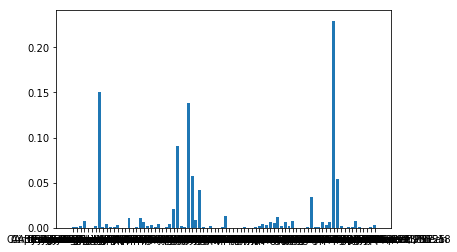

In [9]:
importance = clf.feature_importances_
plt.bar(ship1_seadevcon.columns[:training_data.shape[1]-1].values, importance)
plt.show()

In [10]:
sorted_importance = pd.DataFrame([importance], None, ship1_seadevcon.columns[:training_data.shape[1]-1].values).T
sorted_importance.head()

,0
"Enclosure underpressure GVU, PDS01",0.000048
Inlet gas pressure,0.000389
Gas pressure between shut-off valves,0.057393
Inert gas pressure,0.000311
"Instrument air pressure GVU, PT006",0.000204


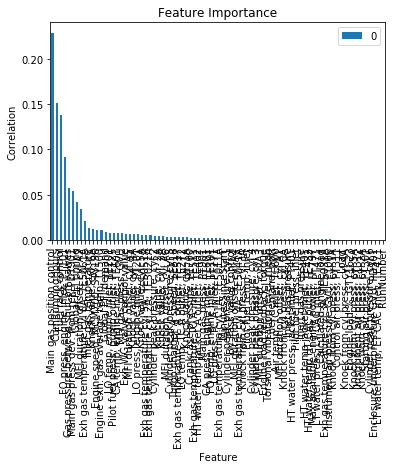

In [11]:
sorted_importance = sorted_importance.sort_values(0, ascending=False)
sorted_importance.plot(kind='bar')
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Correlation")
plt.show()

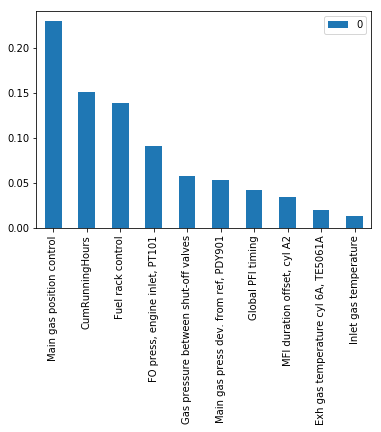

In [12]:
sorted_importance[:10].plot(kind='bar')
plt.show()

Discussion: Sure, 99,88 % makes sense, the fuel used can be predicted easily if all machine data is given. 
The real challange is to find reasons for the fuel change. The data is staying the same as a time series. But the Model must be changed.

In Other Words, we don't need a classification, we need a regression that's mapping the current state to a probability of fuel changes in the future.

Models possible: 
Recurrent neuronal Network
Anything that can handle time series (See also stock marked predictions).
Maybe one decision tree for every time step (2,5,10,15,30,45,60 min into the future). <- would need some data magic (delay the objecive) but looks like it could be a cool idea.
-> Should give a probability of the fuel choice all timesteps in the future. 


<h1>Random Forrest Forecasting</h1>

In [94]:
def series_to_supervised(data, n_in=1, n_out=1, stepsize=5, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in*stepsize, -stepsize, -stepsize):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
            
    # forecast sequence (t+1, ... t+n)
    for i in range(stepsize, n_out*stepsize, stepsize): # t0 ist schon abgedeckt hier drüber. Also start bei t+stepsize
        cols.append(df.iloc[:,-1].shift(-i))
        names += ["Fuel(t+"+str(i)+")"]
        
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [95]:
STEPS_INTO_PAST_AND_FUTURE=6

In [101]:
training_data_timedependent = series_to_supervised(ship1_seadevcon.values, n_in=STEPS_INTO_PAST_AND_FUTURE, n_out=STEPS_INTO_PAST_AND_FUTURE, stepsize=10)
training_data_timedependent.head()

,var1(t-60),var2(t-60),var3(t-60),var4(t-60),var5(t-60),var6(t-60),var7(t-60),var8(t-60),var9(t-60),var10(t-60),...,var79(t-0),var80(t-0),var81(t-0),var82(t-0),var83(t-0),Fuel(t+10),Fuel(t+20),Fuel(t+30),Fuel(t+40),Fuel(t+50)
60,-57.500000,5.8,5.86,8.53,6.320,38.700001,0.0,18.236111,0.0,97.683335,...,46.0,33.0,26.967148,13.227619,0.0,0.0,0.0,0.0,0.0,0.0
61,-57.500000,5.8,5.86,8.53,6.320,38.700001,0.0,18.229268,0.0,97.741669,...,46.0,35.0,27.000482,17.350000,0.0,0.0,0.0,0.0,0.0,0.0
62,-57.500000,5.8,5.86,8.53,6.320,38.700001,0.0,18.285106,0.0,97.800003,...,46.0,37.0,27.033815,46.611818,0.0,0.0,0.0,0.0,0.0,0.0
63,-57.620690,5.8,5.86,8.53,6.320,38.700001,0.0,17.945238,0.0,97.800003,...,46.0,39.0,27.067148,79.561403,0.0,0.0,0.0,0.0,0.0,0.0
64,-57.463415,5.8,5.86,8.53,6.315,38.700001,0.0,18.168182,0.0,97.400002,...,46.0,41.0,27.100482,87.687736,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
''' Split data into training and test set '''

training_data, test_data = train_test_split(training_data_timedependent, test_size=0.2, shuffle=False)
print("taining shape:",training_data.shape,"test shape:",test_data.shape)
print(type(training_data))

taining shape: (325284, 586) test shape: (81321, 586)
<class 'pandas.core.frame.DataFrame'>


In [110]:
# Random Forrest
clf10 = RandomForestClassifier(n_estimators=130, max_features=15, max_depth=7, n_jobs=3, random_state=0)
clf20 = RandomForestClassifier(n_estimators=130, max_features=15, max_depth=7, n_jobs=3, random_state=0)
clf30 = RandomForestClassifier(n_estimators=130, max_features=15, max_depth=7, n_jobs=3, random_state=0)
clf40 = RandomForestClassifier(n_estimators=130, max_features=15, max_depth=7, n_jobs=3, random_state=0)
clf50 = RandomForestClassifier(n_estimators=130, max_features=15, max_depth=7, n_jobs=3, random_state=0)


# get all features but the last one, which is the one we want to predict
features = training_data.columns[:training_data.shape[1]-STEPS_INTO_PAST_AND_FUTURE]

# Train the Classifier to take the training features and learn how they relate to the training y (the species)
# trein STEPS_INTO_PAST_AND_FUTURE Classifiers, one for each step in the future.
clf10.fit(training_data[features], training_data['Fuel(t+10)'])
clf20.fit(training_data[features], training_data['Fuel(t+20)'])
clf30.fit(training_data[features], training_data['Fuel(t+30)'])
clf40.fit(training_data[features], training_data['Fuel(t+40)'])
clf50.fit(training_data[features], training_data['Fuel(t+50)'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=7, max_features=15, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=130, n_jobs=3,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [113]:
pred_results_test_10  = clf10.predict(test_data[features])
pred_results_train_10 = clf10.predict(training_data[features])

pred_results_test_20  = clf20.predict(test_data[features])
pred_results_train_20 = clf20.predict(training_data[features])

pred_results_test_30  = clf30.predict(test_data[features])
pred_results_train_30 = clf30.predict(training_data[features])

pred_results_test_40  = clf40.predict(test_data[features])
pred_results_train_40 = clf40.predict(training_data[features])

pred_results_test_50  = clf50.predict(test_data[features])
pred_results_train_50 = clf50.predict(training_data[features])

pred_res = [[pred_results_test_10, pred_results_train_10], [pred_results_test_20, pred_results_train_20], [pred_results_test_30, pred_results_train_30], [pred_results_test_40, pred_results_train_40], [pred_results_test_50, pred_results_train_50]]

In [120]:
Acc_test = []
Acc_train = []
for time, res in enumerate(pred_res):
    # predict grades for training and test dataset
    Fuel_time = 'Fuel(t+'+str(time*10+10)+')'
    correct_percent_test = 1 - (np.count_nonzero(res[0] - test_data[Fuel_time])/res[0].shape[0])
    Acc_test.append(correct_percent_test)
    correct_percent_train = 1 - np.count_nonzero(res[1] - training_data[Fuel_time])/training_data[Fuel_time].shape[0]
    Acc_train.append(correct_percent_train)
    # l1_loss = np.sum(np.abs(pred_results_test - test_data[Fuel_time].values)) # L1 Loss
    # l2_loss = np.sum(np.square(pred_results_test - test_data[Fuel_time].values)) # L2 Loss

    print("Accuracy test:     for ",Fuel_time, " = ", correct_percent_test)
    print("Accuracy training: for ",Fuel_time, " = ", correct_percent_train)

    #print("\nL1 Loss test:      ", l1_loss)
    #print("L2 Loss test:      ",   l2_loss)

Accuracy test:     for  Fuel(t+10)  =  0.9591126523284268
Accuracy training: for  Fuel(t+10)  =  0.9645786451224161
Accuracy test:     for  Fuel(t+20)  =  0.9483774178871386
Accuracy training: for  Fuel(t+20)  =  0.9615597447153872
Accuracy test:     for  Fuel(t+30)  =  0.9372978689391425
Accuracy training: for  Fuel(t+30)  =  0.9607020326852842
Accuracy test:     for  Fuel(t+40)  =  0.9248287650176461
Accuracy training: for  Fuel(t+40)  =  0.9600134036718683
Accuracy test:     for  Fuel(t+50)  =  0.919713235203699
Accuracy training: for  Fuel(t+50)  =  0.9596229756151547


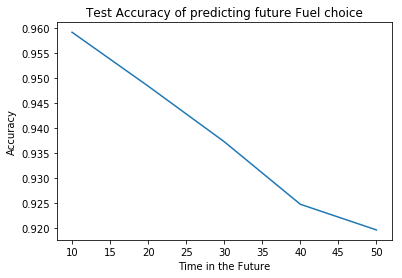

In [126]:
plt.plot([10,20,30,40,50],Acc_test)
plt.title("Test Accuracy of predicting future Fuel choice")
plt.xlabel("Time in the Future")
plt.ylabel("Accuracy")
plt.show()

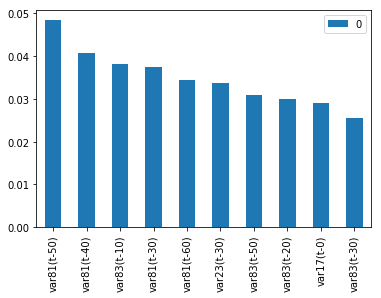

In [129]:
importance = clf50.feature_importances_
sorted_importance = pd.DataFrame([importance], None, training_data.columns[:training_data.shape[1]-STEPS_INTO_PAST_AND_FUTURE].values).T
sorted_importance = sorted_importance.sort_values(0, ascending=False)
sorted_importance[:10].plot(kind='bar')
plt.show()